## Network analysis

Calculate and plot network metrics for the graphs created in the last step as well as some of the Google COVID-19 Mobility Report data for the relevant time periods.

In [1]:
# to allow relative imports
import os
import sys

module = os.path.abspath(os.path.join('..'))
if module not in sys.path:
    sys.path.append(module)

from typing import List
import pickle
import networkx as nx
import matplotlib
from matplotlib import pyplot as plt
import seaborn
from mpmath import polylog
import numpy as np
from functools import partial

from epydemic import PLCNetwork
from model.network.distanced_network import DNGenerator as DNG
from model.distributions import household_size_dist, intra_household_contacts, \
    node_degree_dist

from configuration import OUT, GRAPHS, GRAPHICS
SEED = 4401

Read pickled data created in previous steps.

#### Mobility data

In [2]:
demographics = pickle.load(open(f'{OUT}demographics.pkl', 'rb'))

comb_counts_pre = pickle.load(open(f'{OUT}comb_counts_pre.pkl', 'rb'))
comb_counts_post = pickle.load(open(f'{OUT}comb_counts_post.pkl', 'rb'))

trip_counts_pre = pickle.load(open(f'{OUT}trip_counts_pre.pkl', 'rb'))
trip_counts_post = pickle.load(open(f'{OUT}trip_counts_post.pkl', 'rb'))

g_pre = nx.read_graphml(f'{GRAPHS}pre_N_10000_E_2_C_40.graphml')
g_post = nx.read_graphml(f'{GRAPHS}post_N_10000_E_2_C_40.graphml')

google_mobility_agg = pickle.load(open(f'{OUT}google_mobility_agg.pkl', 'rb'))

#### PLC Network

In [3]:
pre_node_degree_mean = np.mean(list(dict(g_pre.degree()).values()))
post_node_degree_mean = np.mean(list(dict(g_post.degree()).values()))

In [4]:
# calc
def plc_mean(exp, cut):
    nom = polylog(exp-1, np.exp(-1 / cut))
    denom = polylog(exp, np.exp(-1 / cut))
    return nom / denom

def estimate_exponent_for_mean(m, cutoff, tol):
    grid = np.arange(1, 5, 0.01)
    diffs = []
    for i in range(len(grid)):
        diff = abs(m - plc_mean(grid[i], cutoff))
        if diff < tol:
            return grid[i]
        diffs.append(diff)
    
    return grid[diffs.index(min(diffs))]

In [5]:
plc_expo_pre = estimate_exponent_for_mean(pre_node_degree_mean, 40, 0.01)
plc_expo_post = estimate_exponent_for_mean(post_node_degree_mean, 40, 0.01)

In [6]:
params_plc_pre = dict()
params_plc_pre[PLCNetwork.N] = 10000
params_plc_pre[PLCNetwork.EXPONENT] = plc_expo_pre
params_plc_pre[PLCNetwork.CUTOFF] = 40

params_plc_post = dict()
params_plc_post[PLCNetwork.N] = 10000
params_plc_post[PLCNetwork.EXPONENT] = plc_expo_post
params_plc_post[PLCNetwork.CUTOFF] = 40

plc_pre = PLCNetwork(params_plc_pre).generate()
nx.write_graphml(plc_pre, f'{GRAPHS}plc_pre.graphml')

plc_post = PLCNetwork(params_plc_post).generate()
nx.write_graphml(plc_post, f'{GRAPHS}plc_post.graphml')

# from file
plc_pre = nx.read_graphml(f'{GRAPHS}plc_pre.graphml')
plc_post = nx.read_graphml(f'{GRAPHS}plc_post.graphml')

#### Distanced Network

In [7]:
emp_avg_household_size = np.mean([x['household_size'] for x in demographics.values()])

In [8]:
DISTANCED_EXPONENT_PRE = 4
DISTANCED_EXPONENT_POST = 3

average_family = partial(household_size_dist, mu=emp_avg_household_size, std=1)
intra_family_contacts = partial(intra_household_contacts, std=1)
inter_family_contacts = node_degree_dist

params_distanced_pre = dict()
params_distanced_pre[DNG.N] = 10000
params_distanced_pre[DNG.CLUSTER_SIZE_DIST] = average_family
params_distanced_pre[DNG.CONTACT_DIST] = intra_family_contacts
params_distanced_pre[DNG.CLUSTER_CONTACT_DIST] = partial(inter_family_contacts, exponent=DISTANCED_EXPONENT_PRE)
params_distanced_pre[DNG.SEED] = SEED

params_distanced_post = dict()
params_distanced_post[DNG.N] = 10000
params_distanced_post[DNG.CLUSTER_SIZE_DIST] = average_family
params_distanced_post[DNG.CONTACT_DIST] = intra_family_contacts
params_distanced_post[DNG.CLUSTER_CONTACT_DIST] = partial(inter_family_contacts, exponent=DISTANCED_EXPONENT_POST)
params_distanced_post[DNG.SEED] = SEED

distanced_pre = DNG(params_distanced_pre).generate()
nx.write_graphml(distanced_pre, f'{GRAPHS}distanced_pre.graphml')

distanced_post = DNG(params_distanced_post).generate()
nx.write_graphml(distanced_post, f'{GRAPHS}distanced_post.graphml')

# from file
distanced_pre = nx.read_graphml(f'{GRAPHS}distanced_pre.graphml')
distanced_post = nx.read_graphml(f'{GRAPHS}distanced_post.graphml')

#### Metrics

Store all CBG codes in order.

In [9]:
# store all CBGs in order
ordered_cbgs = sorted(demographics.keys())

Calculate density of the networks.

In [10]:
# density
def calc_density(graph: nx.Graph) -> float:
    num_edges = len(graph.edges)
    num_nodes = len(graph.nodes)
    num_edges_max = num_nodes * (num_nodes - 1) / 2
    return num_edges / num_edges_max

In [11]:
%%time

density_dict_pre = {}
density_dict_pre['Mobility'] = [calc_density(g_pre)]
density_dict_pre['PLC'] = [calc_density(plc_pre)]
density_dict_pre['Distanced'] = [calc_density(distanced_pre)]

density_dict_post = {}
density_dict_post['Mobility'] = [calc_density(g_post)]
density_dict_post['PLC'] = [calc_density(plc_post)]
density_dict_post['Distanced'] = [calc_density(distanced_post)]

CPU times: user 48.5 ms, sys: 0 ns, total: 48.5 ms
Wall time: 46.1 ms


Calculate the shortest path length of each pair of nodes in the networks.

In [12]:
# shortest path length

def calc_shortest_paths(graph: nx.Graph) -> List[int]:
    shortest_paths = []
    for x in nx.shortest_path_length(graph):
        shortest_paths.extend(list(x[1].values()))
    return shortest_paths

In [13]:
%%time
shortest_paths = pickle.load(open(f'{OUT}shortest_paths.pkl', 'rb'))

LOAD_FROM_DISK = True

if LOAD_FROM_DISK:
    sp_dict_pre = pickle.load(open(f'{OUT}sp_dict_pre.pkl', 'rb'))
    sp_dict_post = pickle.load(open(f'{OUT}sp_dict_post.pkl', 'rb'))
    
else: 
    sp_dict_pre = {}
    sp_dict_pre['Mobility'] = calc_shortest_paths(g_pre)
    sp_dict_pre['PLC'] = calc_shortest_paths(plc_pre)
    sp_dict_pre['Distanced'] = calc_shortest_paths(distanced_pre)

    sp_dict_post = {}
    sp_dict_post['Mobility'] = calc_shortest_paths(g_post)
    sp_dict_post['PLC'] = calc_shortest_paths(plc_post)
    sp_dict_post['Distanced'] = calc_shortest_paths(distanced_post)
    
    pickle.dump(sp_dict_pre, open(f'{OUT}sp_dict_pre.pkl', 'wb'))
    pickle.dump(sp_dict_post, open(f'{OUT}sp_dict_post.pkl', 'wb'))

CPU times: user 54min 44s, sys: 19.4 s, total: 55min 3s
Wall time: 55min 4s


Calculate the cluster coefficients for each networks.

In [14]:
# cluster coefficient
def calc_cluster_coeff(graph: nx.Graph) -> List[float]:
    coefficients = nx.clustering(graph)
    return list(coefficients.values())

In [15]:
%%time

clustering_dict_pre = {}
clustering_dict_pre['Mobility'] = calc_cluster_coeff(g_pre)
clustering_dict_pre['PLC'] = calc_cluster_coeff(plc_pre)
clustering_dict_pre['Distanced'] = calc_cluster_coeff(distanced_pre)

clustering_dict_post = {}
clustering_dict_post['Mobility'] = calc_cluster_coeff(g_post)
clustering_dict_post['PLC'] = calc_cluster_coeff(plc_post)
clustering_dict_post['Distanced'] = calc_cluster_coeff(distanced_post)

CPU times: user 1.96 s, sys: 0 ns, total: 1.96 s
Wall time: 1.96 s


Extract the network degrees.

In [16]:
%%time

degrees_dict_pre = {}
degrees_dict_pre['Mobility'] = list(dict(g_pre.degree()).values())
degrees_dict_pre['PLC'] = list(dict(plc_pre.degree()).values())
degrees_dict_pre['Distanced'] = list(dict(distanced_pre.degree()).values())

degrees_dict_post = {}
degrees_dict_post['Mobility'] = list(dict(g_post.degree()).values())
degrees_dict_post['PLC'] = list(dict(plc_post.degree()).values())
degrees_dict_post['Distanced'] = list(dict(distanced_post.degree()).values())

CPU times: user 92.5 ms, sys: 0 ns, total: 92.5 ms
Wall time: 92.1 ms


### Mobility Visualisations

Define helper functions for plotting.

In [17]:
# set the colors of pairs of boxplots to red and blue.
def set_alternating_boxplot_colors(bp):
    
    if len(bp['medians']) >= 2:
        bp['medians'][0].set_color('firebrick')
        bp['medians'][1].set_color('steelblue')
    
    if len(bp['means']) >= 2:
        bp['means'][0].set_markerfacecolor('firebrick')
        bp['means'][1].set_markerfacecolor('steelblue')
    
    if len(bp['boxes']) >= 2:
        bp['boxes'][0].set_color('firebrick')
        bp['boxes'][1].set_color('steelblue')
    
    if len(bp['caps']) >= 4:
        bp['caps'][0].set_color('firebrick')
        bp['caps'][1].set_color('firebrick')
        bp['caps'][2].set_color('steelblue')
        bp['caps'][3].set_color('steelblue')

    if len(bp['whiskers']) >= 4:
        bp['whiskers'][0].set_color('firebrick')
        bp['whiskers'][1].set_color('firebrick')
        bp['whiskers'][2].set_color('steelblue')
        bp['whiskers'][3].set_color('steelblue')


def set_boxplot_color(bp, color):
    
    for cat in bp:
        for i in range(len(bp[cat])):
            bp[cat][i].set_color(color)
            try:
                bp[cat][i].set_markerfacecolor(color)
            except AttributeError:
                pass

Visualise the trip counts of the Patterns data and data from the Google COVID-19 Mobility Report.

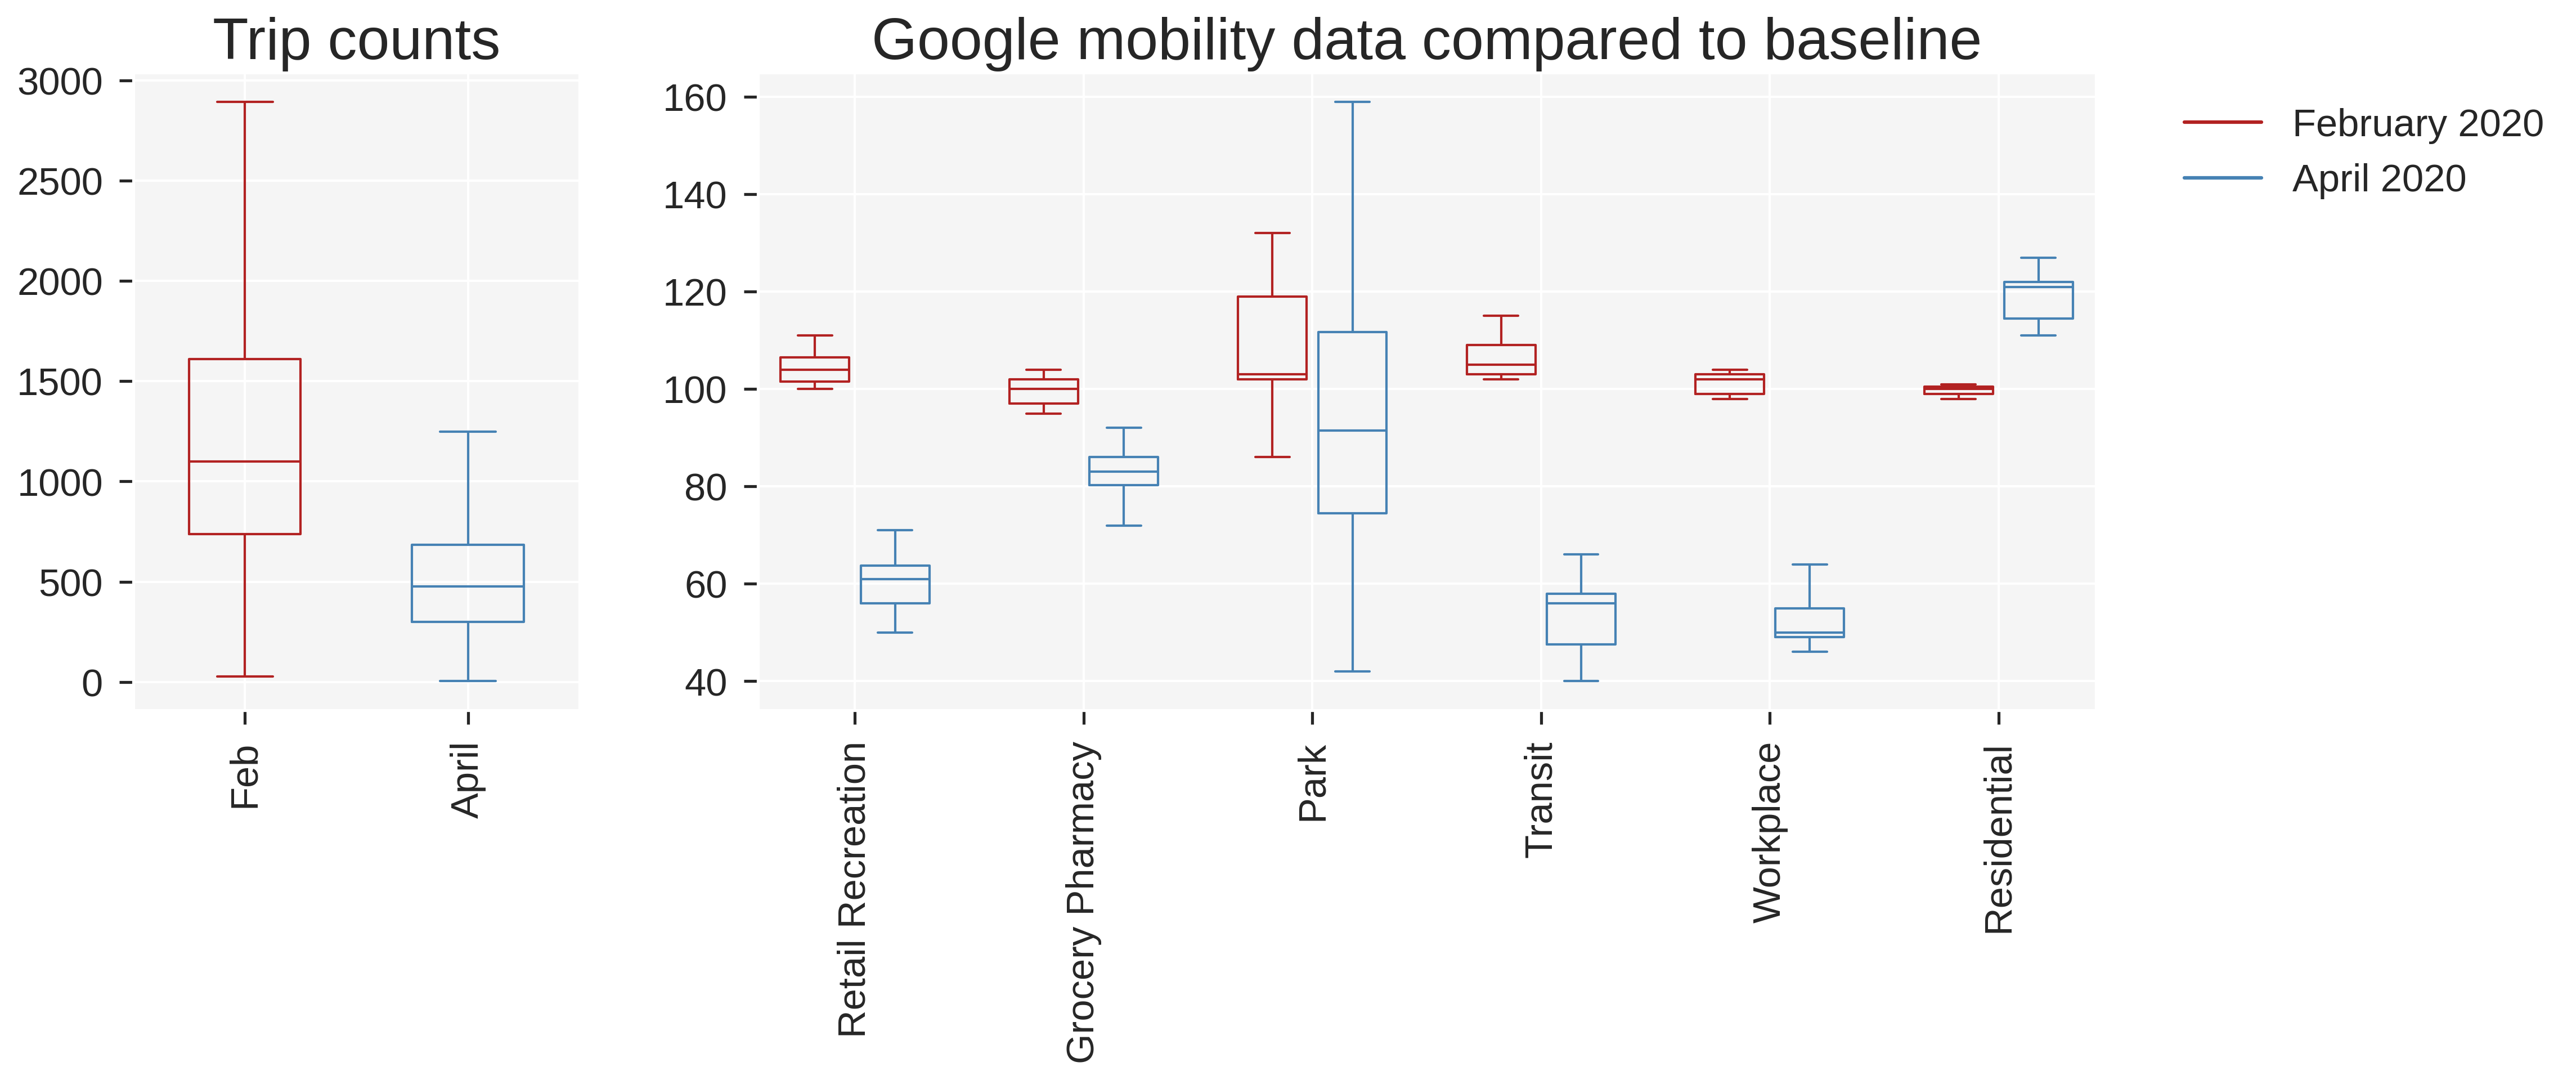

In [18]:
matplotlib.style.use('seaborn')
matplotlib.rcParams['figure.dpi'] = 300
seaborn.set_context('notebook', font_scale=1.5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), facecolor='w', gridspec_kw={'width_ratios': [1, 3]})

# trip counts
data_trips = [list(trip_counts_pre.values()), list(trip_counts_post.values())]
bp = ax1.boxplot(data_trips, showfliers=False, widths=0.5)
set_alternating_boxplot_colors(bp)

ax1.set_facecolor('#F5F5F5')
ax1.set_title('Trip counts', fontsize=25)
ax1.set_xticks([1, 2])
ax1.set_xticklabels(['Feb', 'April'], rotation=90)

# google
categories = [' '.join([w.capitalize() for w in x.split('_')]) 
              for x in google_mobility_agg[2].keys()]

c = 1
for k in google_mobility_agg[2].keys():
    data = [google_mobility_agg[2][k], google_mobility_agg[4][k]]
    bp = ax2.boxplot(data, positions = [c+0.15, c+0.85], widths=0.6, showfliers=False)
    set_alternating_boxplot_colors(bp)
    
    c += 2

ax2.set_title('Google mobility data compared to baseline', fontsize=25)
ax2.set_xticks([1.5 + i*2 for i, _ in enumerate(categories)])
ax2.set_xticklabels(list(categories), rotation=90)
ax2.set_facecolor('#F5F5F5')

_ = plt.plot([], color='firebrick', label='February 2020', ls='-')
_ = plt.plot([], color='steelblue', label='April 2020')
_ = plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.savefig(f'{GRAPHICS}mobility-metrics.png', bbox_inches="tight")
plt.show()

Visualise network metrics for both graphs.

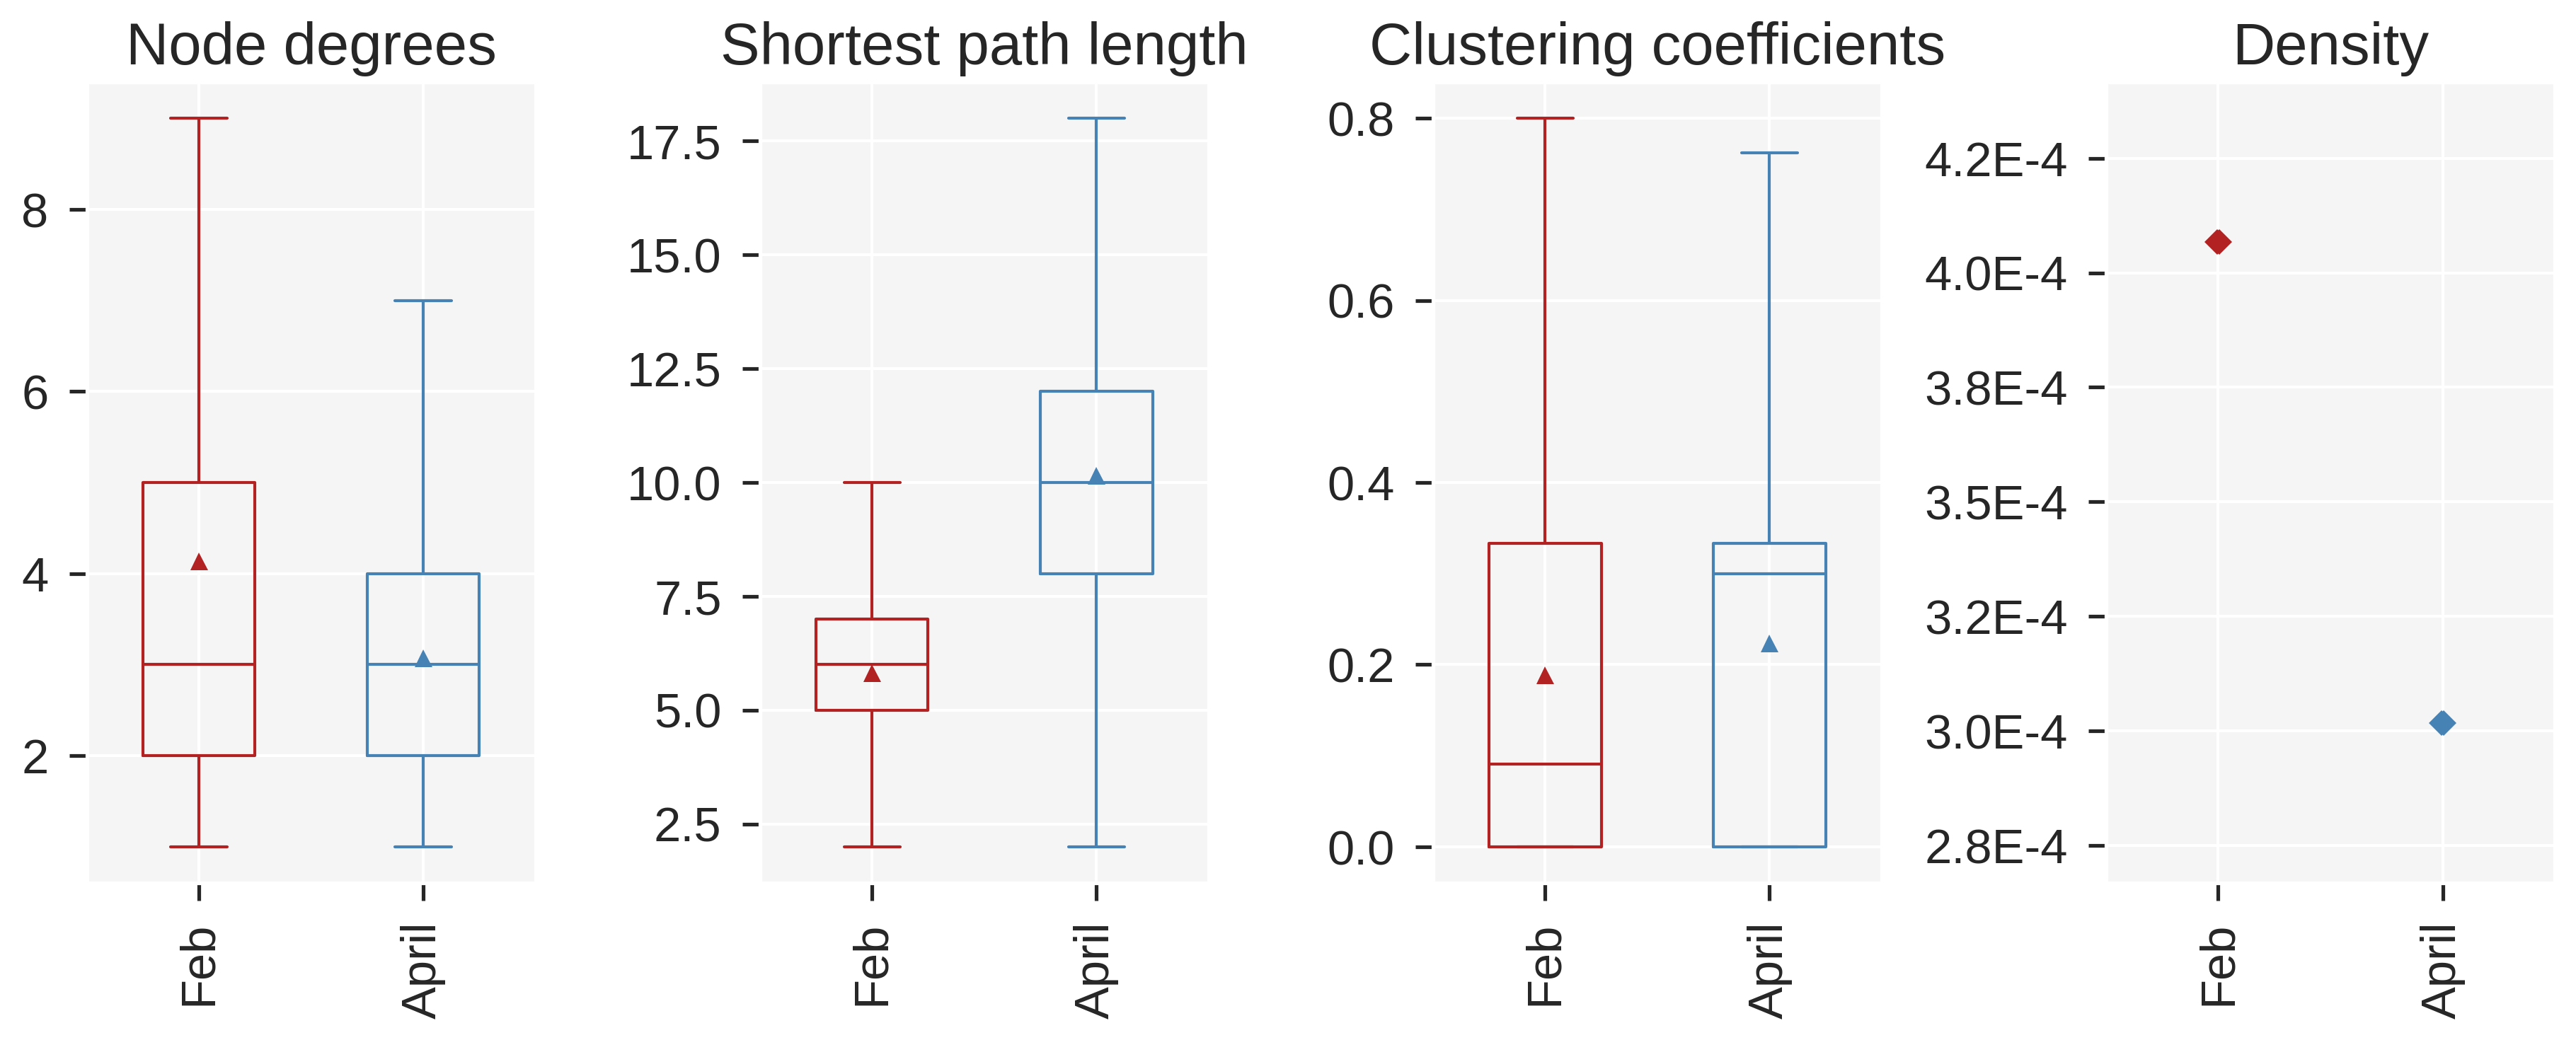

In [19]:
matplotlib.style.use('seaborn')
matplotlib.rcParams['figure.dpi'] = 300
seaborn.set_context('notebook', font_scale=1.5)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,5), facecolor='w', 
                                         gridspec_kw={'width_ratios': [1, 1, 1, 1]})

# degrees
bp = ax1.boxplot([degrees_dict_pre['Mobility'], degrees_dict_post['Mobility']], 
                 showfliers=False, widths=0.5, showmeans=True)
set_alternating_boxplot_colors(bp)

ax1.set_facecolor('#F5F5F5')
ax1.set_title('Node degrees', fontsize=20)
ax1.set_xticks([1, 2])
ax1.set_xticklabels(['Feb', 'April'], rotation=90)

# shortest path
bp = ax2.boxplot([sp_dict_pre['Mobility'], sp_dict_post['Mobility']], 
                 showfliers=False, widths=0.5, showmeans=True)
set_alternating_boxplot_colors(bp)

ax2.set_facecolor('#F5F5F5')
ax2.set_title('Shortest path length', fontsize=20)
ax2.set_xticks([1, 2])
ax2.set_xticklabels(['Feb', 'April'], rotation=90)

# clustering coefficient
bp = ax3.boxplot([clustering_dict_pre['Mobility'], clustering_dict_post['Mobility']], 
                 showfliers=False, widths=0.5, showmeans=True)
set_alternating_boxplot_colors(bp)

ax3.set_facecolor('#F5F5F5')
ax3.set_title('Clustering coefficients', fontsize=20)
ax3.set_xticks([1, 2])
ax3.set_xticklabels(['Feb', 'April'], rotation=90)

# density
medianprops = dict(linewidth=4, marker='D')
densities = [density_dict_pre['Mobility'], density_dict_post['Mobility']]
bp = ax4.boxplot(densities, showfliers=False, medianprops=medianprops, widths=0.01)
set_alternating_boxplot_colors(bp)

margin = abs(densities[0][0] - densities[1][0]) / 3
y_low = min(densities[0][0], densities[1][0]) - margin
y_up = max(densities[0][0], densities[1][0]) + margin
del densities

fmt = lambda x, _: '{:.1f}'.format(x*10000) + 'E-4'

ax4.set_ylim(y_low, y_up)
ax4.yaxis.set_major_formatter(fmt)
ax4.set_facecolor('#F5F5F5')
ax4.set_title('Density', fontsize=20)
ax4.set_xticks([1, 2])
ax4.set_xticklabels(['Feb', 'April'], rotation=90)

plt.subplots_adjust(wspace=0.5)
plt.savefig(f'{GRAPHICS}network-metrics.png', bbox_inches="tight")
plt.show()

### Network comparisons

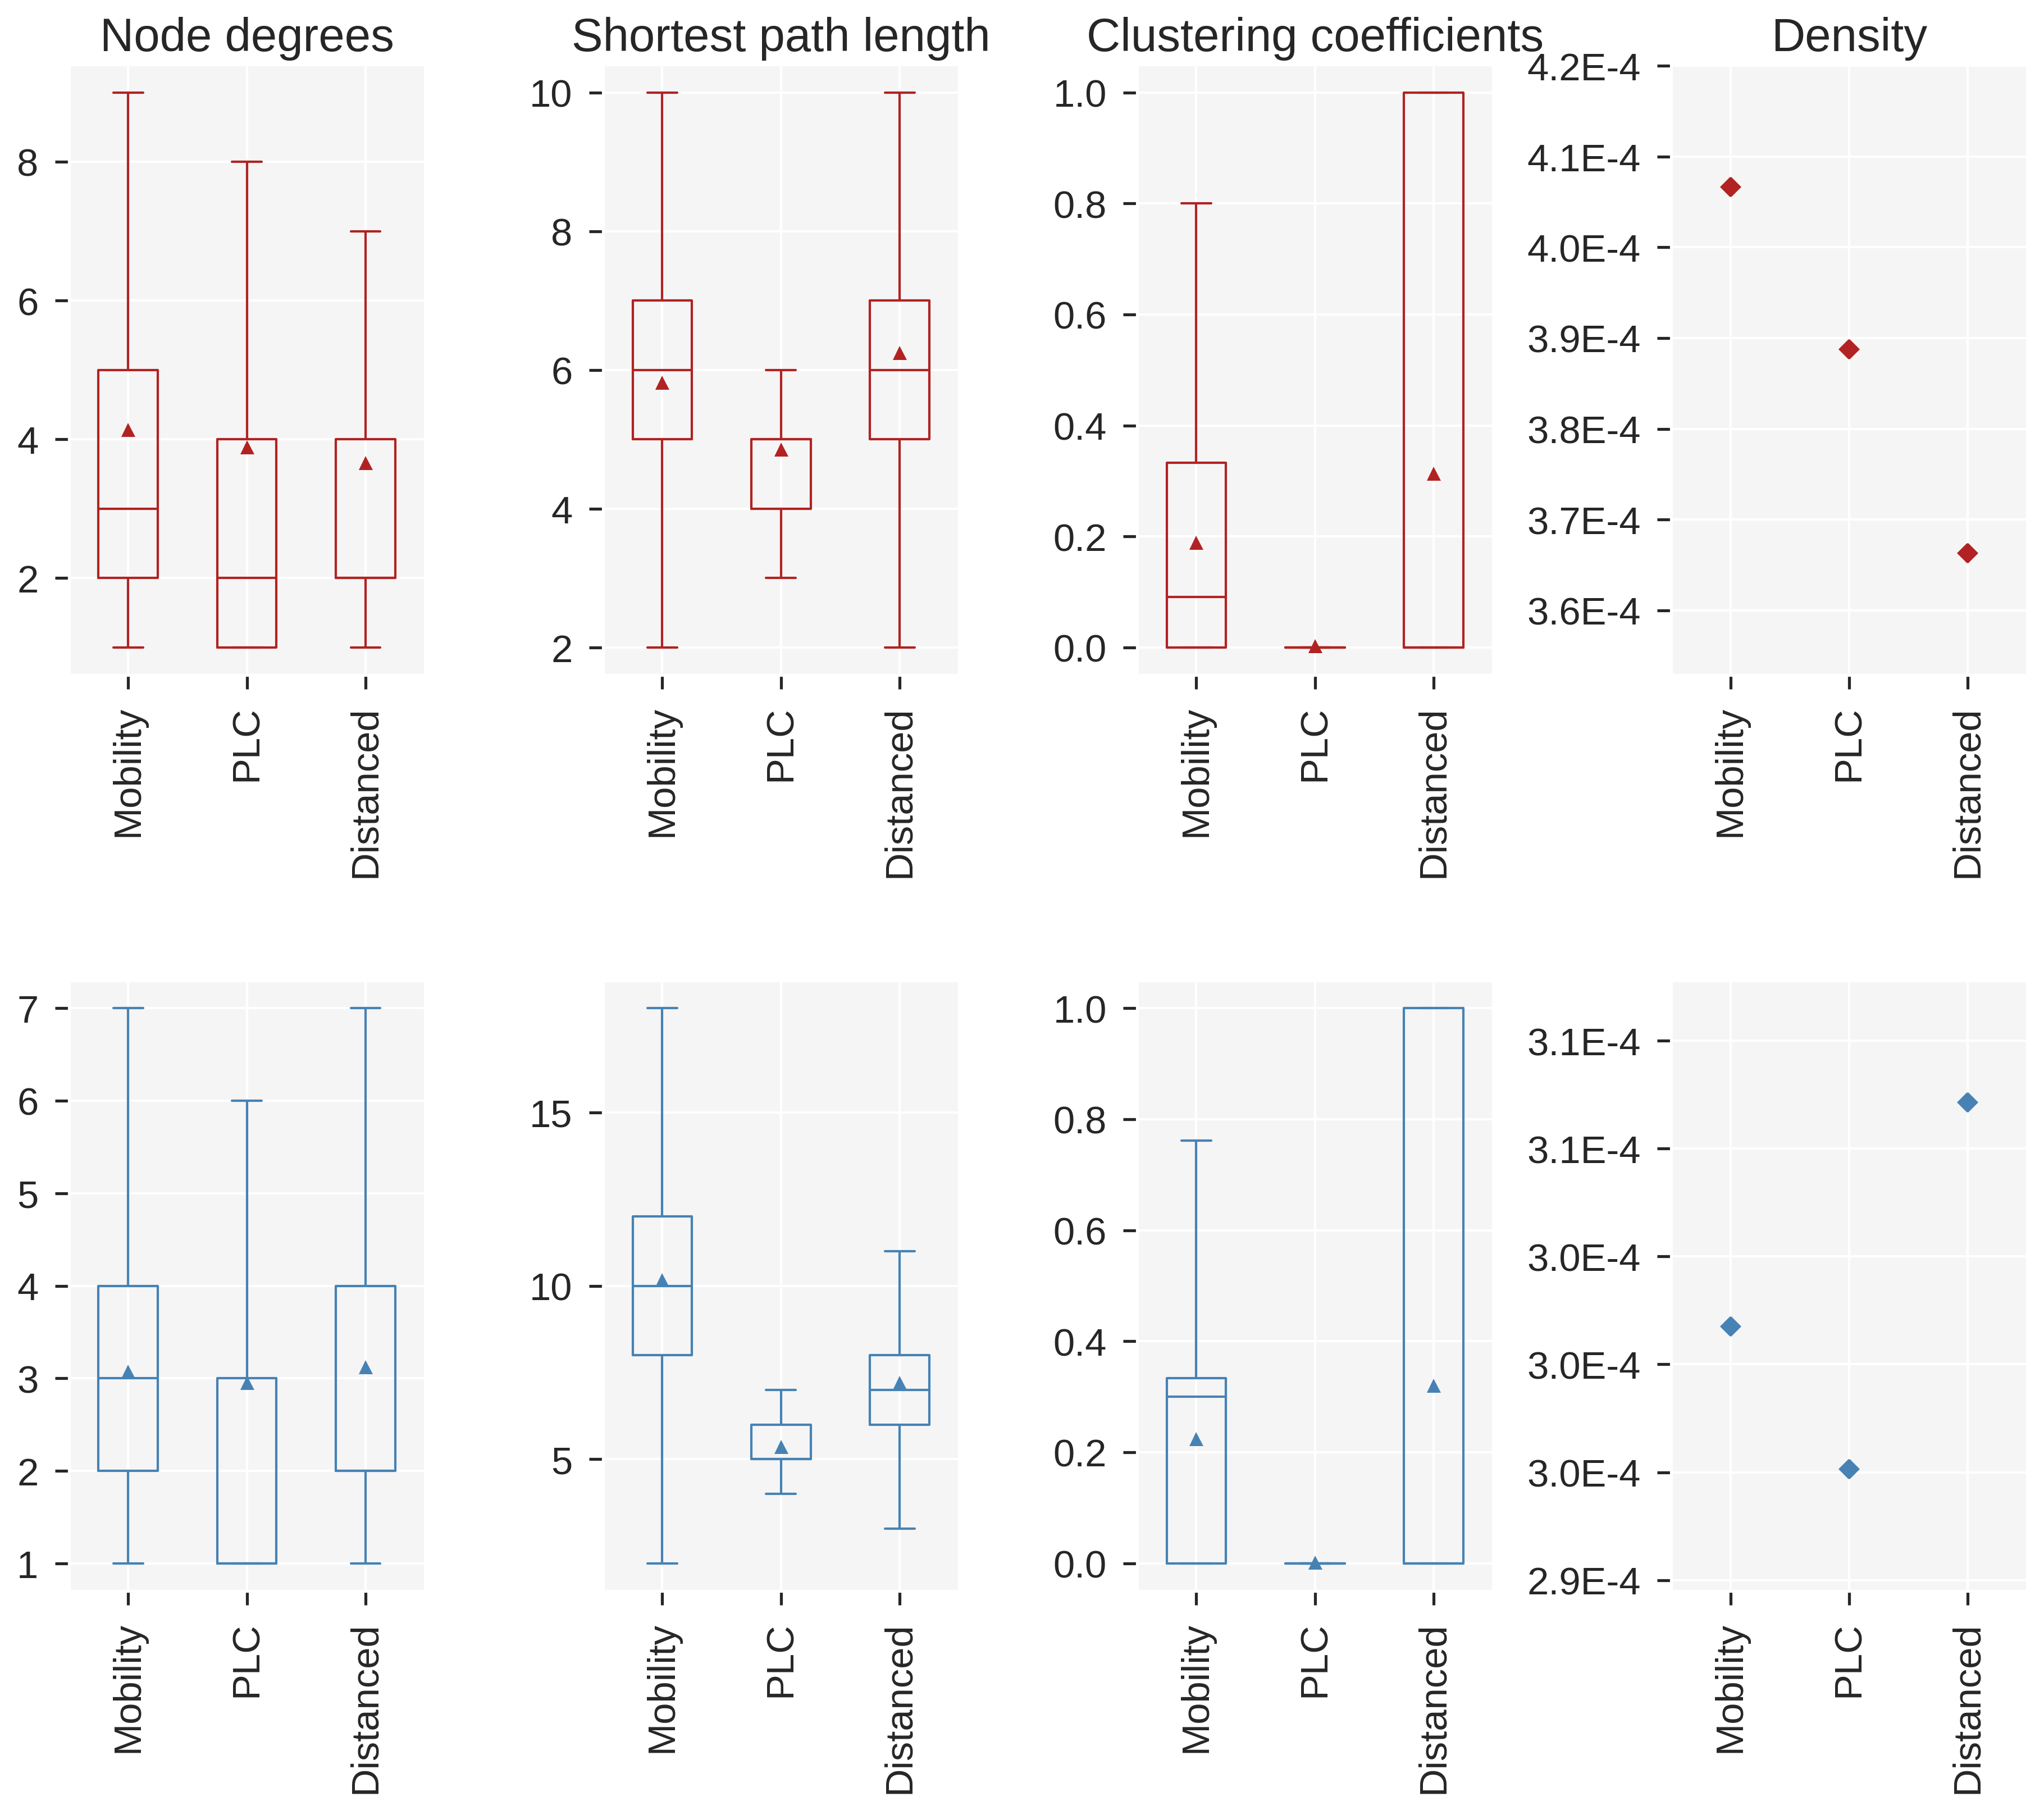

In [20]:
matplotlib.style.use('seaborn')
matplotlib.rcParams['figure.dpi'] = 300
seaborn.set_context('notebook', font_scale=1.5)

fig, (r1, r2) = plt.subplots(2, 4, figsize=(15, 12), facecolor='w', 
                             gridspec_kw={'width_ratios': [1, 1, 1, 1]})

ax1, ax2, ax3, ax4 = r1
ax5, ax6, ax7, ax8 = r2

# degrees
bp = ax1.boxplot(degrees_dict_pre.values(), showfliers=False, widths=0.5, showmeans=True)
set_boxplot_color(bp, 'firebrick')

ax1.set_facecolor('#F5F5F5')
ax1.set_title('Node degrees', fontsize=20)
ax1.set_xticks([i+1 for i in range(len(degrees_dict_pre))])
ax1.set_xticklabels(degrees_dict_pre.keys(), rotation=90)

# shortest path
bp = ax2.boxplot(sp_dict_pre.values(), showfliers=False, widths=0.5, showmeans=True)
set_boxplot_color(bp, 'firebrick')

ax2.set_facecolor('#F5F5F5')
ax2.set_title('Shortest path length', fontsize=20)
ax2.set_xticks([i+1 for i in range(len(sp_dict_pre))])
ax2.set_xticklabels(sp_dict_pre.keys(), rotation=90)

# clustering coefficient
bp = ax3.boxplot(clustering_dict_pre.values(), showfliers=False, widths=0.5, showmeans=True)
set_boxplot_color(bp, 'firebrick')

ax3.set_facecolor('#F5F5F5')
ax3.set_title('Clustering coefficients', fontsize=20)
ax3.set_xticks([i+1 for i in range(len(clustering_dict_pre))])
ax3.set_xticklabels(clustering_dict_pre.keys(), rotation=90)

# density
medianprops = dict(linewidth=4, marker='D')
bp = ax4.boxplot(density_dict_pre.values(), showfliers=False, medianprops=medianprops, widths=0.01)
set_boxplot_color(bp, 'firebrick')

val_min = min([x for l in density_dict_pre.values() for x in l])
val_max = max([x for l in density_dict_pre.values() for x in l])
margin = (val_max - val_min) / 3

fmt = lambda x, _: '{:.1f}'.format(x*10000) + 'E-4'

ax4.set_ylim(val_min - margin, val_max + margin)
ax4.yaxis.set_major_formatter(fmt)
ax4.set_facecolor('#F5F5F5')
ax4.set_title('Density', fontsize=20)
ax4.set_xticks([i+1 for i in range(len(density_dict_pre))])
ax4.set_xticklabels(density_dict_pre.keys(), rotation=90)

### 2nd row

# degrees
bp = ax5.boxplot(degrees_dict_post.values(), showfliers=False, widths=0.5, showmeans=True)
set_boxplot_color(bp, 'steelblue')

ax5.set_facecolor('#F5F5F5')
ax5.set_xticks([i+1 for i in range(len(degrees_dict_post))])
ax5.set_xticklabels(degrees_dict_post.keys(), rotation=90)

# shortest path
bp = ax6.boxplot(sp_dict_post.values(), showfliers=False, widths=0.5, showmeans=True)
set_boxplot_color(bp, 'steelblue')

ax6.set_facecolor('#F5F5F5')
ax6.set_xticks([i+1 for i in range(len(sp_dict_post))])
ax6.set_xticklabels(sp_dict_post.keys(), rotation=90)

# clustering coefficient
_ = bp = ax7.boxplot(clustering_dict_post.values(), showfliers=False, widths=0.5, showmeans=True)
set_boxplot_color(bp, 'steelblue')

ax7.set_facecolor('#F5F5F5')
ax7.set_xticks([i+1 for i in range(len(clustering_dict_post))])
ax7.set_xticklabels(clustering_dict_post.keys(), rotation=90)

# density
medianprops = dict(linewidth=4, marker='D')
bp = ax8.boxplot(density_dict_post.values(), showfliers=False, medianprops=medianprops, widths=0.01)
set_boxplot_color(bp, 'steelblue')

val_min = min([x for l in density_dict_post.values() for x in l])
val_max = max([x for l in density_dict_post.values() for x in l])
margin = (val_max - val_min) / 3

ax8.set_ylim(val_min - margin, val_max + margin)
ax8.yaxis.set_major_formatter(fmt)
ax8.set_facecolor('#F5F5F5')
ax8.set_xticks([i+1 for i in range(len(density_dict_post))])
ax8.set_xticklabels(density_dict_post.keys(), rotation=90)

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig(f'{GRAPHICS}comparison-network-metrics.png', bbox_inches="tight")
plt.show()

In [21]:
def node_degree_dist(exponent: float,
                     seed = None) -> int:
    """
    Return node degree from an exponential distribution.
    :param exponent: Exponent of the exponential distribution.
    :param seed: (optional) Random seed.
    :returns: Number of connections to outside the household.
    """
    rng = np.random.default_rng(seed=seed)
    return max(int(rng.exponential(exponent)), 1)

def intra_household_contacts(size: int, std: float = 1,
                             seed = None) -> int:
    """
    Draw random number of contacts within a household.
    :param size: households size
    :param std: standard deviation. defaults to 1.
    :param seed: random seed
    :return: number of intra household contact
    """
    rng = np.random.default_rng(seed=seed)
    return max(int(rng.normal(min(size / 2, 1), std)), 1)